# 📈 Gelişmiş Türkçe Metin Analizi: TF-IDF, LSTM ve Doğrulama
Bu notebook, Türkçe yorumlarla duygu analizi yapmak için TF-IDF ve LSTM modellerini kullanır. Eğitim/Doğrulama ayrımı, model performansı ve grafiklerle desteklenmiştir.

In [1]:
!pip install tensorflow scikit-learn matplotlib nltk

In [2]:

import re
import numpy as np
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

nltk.download('stopwords')
stop_words = set(stopwords.words("turkish"))

def temizle_ve_tokenize(metin):
    temiz_metin = re.sub(r"[^\w\s]", "", metin)
    temiz_metin = temiz_metin.lower()
    kelimeler = temiz_metin.split()
    temiz_kelimeler = [k for k in kelimeler if k not in stop_words]
    return " ".join(temiz_kelimeler)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:

yorumlar = [
    "Film çok güzeldi, bayıldım!",
    "Hiç beğenmedim, çok sıkıcıydı.",
    "Oyunculuk harikaydı ama senaryo zayıftı.",
    "Bu kadar kötü bir film izlememiştim.",
    "Görsel efektler başarılıydı.",
    "Kurgusu çok iyiydi, çok etkilendim.",
    "Zaman kaybıydı, hiç sevmedim.",
    "Efektler dışında her şey berbattı.",
    "Hikaye sürükleyiciydi ve oyunculuk da çok iyiydi.",
    "Sıkıldım, tekrar izlemem."
]
etiketler = np.array([1, 0, 1, 0, 1, 1, 0, 0, 1, 0])

temizlenmis_yorumlar = [temizle_ve_tokenize(y) for y in yorumlar]

# Eğitim ve doğrulama ayrımı
X_train, X_test, y_train, y_test = train_test_split(temizlenmis_yorumlar, etiketler, test_size=0.2, random_state=42)


In [4]:

tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=10)
X_test_pad = pad_sequences(X_test_seq, maxlen=10)


In [5]:

model = Sequential()
model.add(Embedding(input_dim=1000, output_dim=32, input_length=10))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Erken durdurma (overfitting önlemi)
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Eğitim
history = model.fit(X_train_pad, y_train, validation_data=(X_test_pad, y_test), epochs=20, callbacks=[early_stop])


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5000 - loss: 0.6925 - val_accuracy: 0.5000 - val_loss: 0.6964
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.6250 - loss: 0.6911 - val_accuracy: 0.0000e+00 - val_loss: 0.6959
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7500 - loss: 0.6896 - val_accuracy: 0.0000e+00 - val_loss: 0.6954
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.8750 - loss: 0.6881 - val_accuracy: 0.0000e+00 - val_loss: 0.6950
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 1.0000 - loss: 0.6866 - val_accuracy: 0.0000e+00 - val_loss: 0.6945
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 1.0000 - loss: 0.6850 - val_accuracy: 0.0000e+00 - val_loss: 0.6940
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 0.6833 - val_accuracy: 0.5000 - val_loss: 0.6936
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 0.6816 - val_accuracy: 0.5000 - val_lo

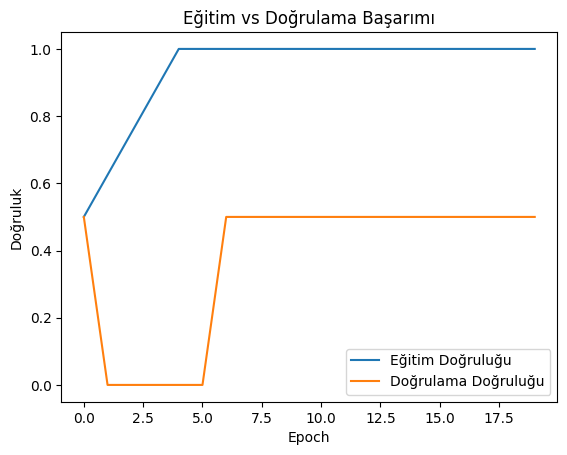

In [6]:

plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.title('Eğitim vs Doğrulama Başarımı')
plt.show()


In [7]:

# Modeli kaydet
model.save("duygu_modeli.h5")
print("Model kaydedildi.")

# Modeli yüklemek istersen:
# from tensorflow.keras.models import load_model
# model = load_model("duygu_modeli.h5")


Model kaydedildi.


In [13]:

def yorum_tahmin_et(yorum):
    temiz = temizle_ve_tokenize(yorum)
    seq = tokenizer.texts_to_sequences([temiz])
    pad_seq = pad_sequences(seq, maxlen=10)
    tahmin = model.predict(pad_seq)[0][0]
    print(f"Yorum: {yorum}")
    print(f"Tahmin (0=olumsuz, 1=olumlu): {tahmin:.2f}")

# Örnek yorum tahminleri
yorum_tahmin_et("Film gerçekten çok etkileyiciydi, bayıldım.")
yorum_tahmin_et("Bu ne biçim filmdi ya, hiç beğenmedim nefret ettim")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Yorum: Film gerçekten çok etkileyiciydi, bayıldım.
Tahmin (0=olumsuz, 1=olumlu): 0.51
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Yorum: Bu ne biçim filmdi ya, hiç beğenmedim nefret ettim
Tahmin (0=olumsuz, 1=olumlu): 0.51


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


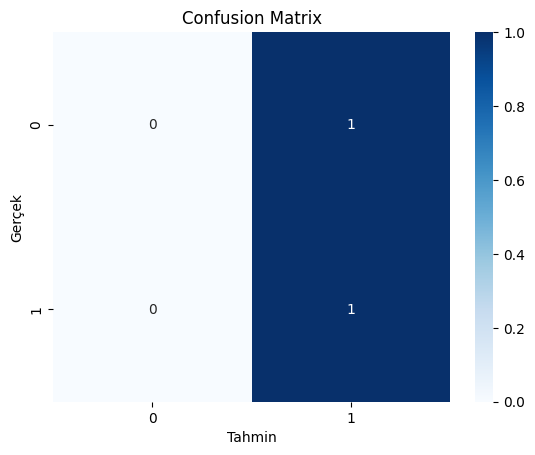

              precision    recall  f1-score   support

           0      0.000     0.000     0.000         1
           1      0.500     1.000     0.667         1

    accuracy                          0.500         2
   macro avg      0.250     0.500     0.333         2
weighted avg      0.250     0.500     0.333         2



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [9]:

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Test seti için tahmin
y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")

# Confusion matrix çiz
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.title("Confusion Matrix")
plt.show()

# Rapor
print(classification_report(y_test, y_pred, digits=3))
